This is a simple starter notebook to help you get started with the hackathon



In [1]:
# !pip install xgboost
from xgboost import XGBRegressor



In [2]:
# import libraries
import os
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Linear models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, ARDRegression,
    HuberRegressor, RANSACRegressor, TheilSenRegressor,
    SGDRegressor,
    PoissonRegressor, GammaRegressor, TweedieRegressor
)

# Ensemble models
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    HistGradientBoostingRegressor, AdaBoostRegressor,
    BaggingRegressor, ExtraTreesRegressor,
    StackingRegressor, VotingRegressor
)

# Tree-based model
from sklearn.tree import DecisionTreeRegressor

# Support Vector Regression
from sklearn.svm import SVR, LinearSVR

# Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

# Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor

# Neural Networks
from sklearn.neural_network import MLPRegressor

In [4]:
# Set seed for reproducability
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)


## Loading and previewing data

In [5]:
DATA_PATH = 'data'
SUBMISSION_PATH = 'submissions'
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
# samplesubmission = pd.read_csv(os.path.join(SUBMISSION_PATH, 'SampleSubmission.csv'))
weather_df = pd.read_csv(os.path.join(DATA_PATH, 'Accra_weather.csv'), index_col=0)
variable_def = pd.read_csv(os.path.join(DATA_PATH, 'VariableDefinitions.csv'))

In [ ]:
variable_def

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
weather_df.head()

In [6]:
def extract_datetime_features(data, cols: list):
    df = data.copy()
    for col in cols:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_hour'] = df[col].dt.hour
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_month'] = df[col].dt.month

    return df

In [7]:
# extract datetime features
train = extract_datetime_features(train, ['lcl_start_transporting_dttm'])
test = extract_datetime_features(test, ['lcl_start_transporting_dttm'])
weather_df = extract_datetime_features(weather_df, ['lcl_datetime'])

# Preview train dataset
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18,9,5,5
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93,10,21,5
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02,21,5,5
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80,21,26,5
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23,14,30,5


In [ ]:
# Preview test dataset
test.head()

In [ ]:
# Preview sample submission file


In [ ]:
# Preview graph data
weather_df.head()

In [ ]:
# Check size and shape of datasets
train.shape, test.shape

In [ ]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])


## Statistical summaries

In [ ]:
# Train statistical summary
train.describe(include = 'number')  # could also do include = 'all' or 'object'

Some insights from the above summary:
 - The train data provided has 57 596 data points
 - The average trip time is 10.08 mins
 - The shortest trip took a 1.02 minute while the longest took 585.93 mins (possible outliers)

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.Target)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.Target.skew())

The target variable appears to be right skewed




## Outliers


In [ ]:
# Plotting boxplot for travel time
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.Target)
plt.title('Boxplot showing travel time outliers', y = 1.02, fontsize = 15)
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...



## Weather data

In [ ]:
weather_df.lcl_datetime.min(), weather_df.lcl_datetime.max()

In [ ]:
weather_df.describe(include='all')

Some insights from the above summary:

 - An average of 0.151mm of precipitation was recorded in May 2024
 - Highest precipitation was 4.34mm
 - Average temp in May was 28.30 deg Celcius with a range between 25.92 and 30.49 degrees Celcius


Let's merge the weather and trips data

In [ ]:
train.head()

In [8]:
# create day_hour variable to merge trips and weather data on
train['day_hour'] = train['lcl_start_transporting_dttm_day'].astype(str).str.split('.').str[0] +\
 '_' + train['lcl_start_transporting_dttm_hour'].astype(str).str.split('.').str[0]

test['day_hour'] = test['lcl_start_transporting_dttm_day'].astype(str).str.split('.').str[0] +\
 '_' + test['lcl_start_transporting_dttm_hour'].astype(str).str.split('.').str[0]

weather_df['day_hour'] = weather_df['lcl_datetime_day'].astype(str).str.split('.').str[0] +\
 '_' + weather_df['lcl_datetime_hour'].astype(str).str.split('.').str[0]

In [9]:
train = train.merge(weather_df, on='day_hour', how='left')
test = test.merge(weather_df, on='day_hour', how='left')

In [ ]:
train.head()

In [ ]:
test.head()


## Missing values and duplicates

In [ ]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [ ]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()


## Correlations

In [ ]:
# Top 20 correlated features to the target
top20_corrs = abs(train.select_dtypes(include='number').corr()['Target']).sort_values(ascending = False).head(20)
top20_corrs

In [ ]:
cols = ['destination_lat','destination_lon','origin_lat','origin_lon',
        'str_distance_km','transporting_distance_fact_km', 'lcl_start_transporting_dttm_day',
        'lcl_start_transporting_dttm_month', 'prev_hour_precipitation_mm', 'temperature_C', 'Target']

# Plotting a heatmap to show correlations between variables
corr = train[cols].corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [ ]:
# # Linear models
# from sklearn.linear_model import (
#     LinearRegression, Ridge, Lasso, ElasticNet,
#     BayesianRidge, ARDRegression,
#     HuberRegressor, RANSACRegressor, TheilSenRegressor,
#     SGDRegressor,
#     PoissonRegressor, GammaRegressor, TweedieRegressor
# )

# # Ensemble models
# from sklearn.ensemble import (
#     RandomForestRegressor, GradientBoostingRegressor,
#     HistGradientBoostingRegressor, AdaBoostRegressor,
#     BaggingRegressor, ExtraTreesRegressor,
#     StackingRegressor, VotingRegressor
# )

# # Tree-based model
# from sklearn.tree import DecisionTreeRegressor

# # Support Vector Regression
# from sklearn.svm import SVR, LinearSVR

# # Nearest Neighbors
# from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

# # Gaussian Process Regression
# from sklearn.gaussian_process import GaussianProcessRegressor

# # Neural Networks
# from sklearn.neural_network import MLPRegressor


## Modelling

In [10]:
# =====================================
# 🧼 Remove Outliers in Target
# =====================================
q_low = train['Target'].quantile(0.0)
q_high = train['Target'].quantile(0.999)
train = train[(train['Target'] >= q_low) & (train['Target'] <= q_high)]

In [11]:
# =====================================
# 🧠 FEATURE ENGINEERING FUNCTION FOR TRIPS
# =====================================
def create_trip_features(df):
    df = df.copy()

    # Parse datetime columns
    df['lcl_start_transporting_dttm'] = pd.to_datetime(df['lcl_start_transporting_dttm'])
    df['hour'] = df['lcl_start_transporting_dttm'].dt.hour
    df['day'] = df['lcl_start_transporting_dttm'].dt.day
    df['month'] = df['lcl_start_transporting_dttm'].dt.month
    df['dayofweek'] = df['lcl_start_transporting_dttm'].dt.weekday
    df['weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Rush hour
    df['rush_hour'] = ((df['hour'].between(7, 9)) | (df['hour'].between(17, 19))).astype(int)

    # Sine/Cosine transforms for hour of day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Distance ratio (handle division by zero)
    df['distance_ratio'] = np.where(df['str_distance_km'] > 0,
                                    df['transporting_distance_fact_km'] / df['str_distance_km'],
                                    1.0)
    df['distance_ratio'] = np.clip(df['distance_ratio'], 0, 10)

    # Distance difference
    df['distance_diff'] = df['transporting_distance_fact_km'] - df['str_distance_km']

    # Distance bucket
    df['distance_bucket'] = pd.cut(df['transporting_distance_fact_km'], bins=[0, 2, 5, 10, 20, 50], labels=False)

    # Time of day bucket
    df['time_bucket'] = pd.cut(df['hour'], bins=[-1, 6, 12, 17, 21, 24], labels=[0, 1, 2, 3, 4])

    # Add day_hour for merging with weather
    df['day_hour'] = df['day'].astype(str) + '_' + df['hour'].astype(str)

    return df

In [12]:
# Apply to datasets
train = create_trip_features(train)
test = create_trip_features(test)



In [13]:
# Selecting the independent variables and the target variable
feature_cols = ['str_distance_km', 'temperature_C','transporting_distance_fact_km',
           'lcl_start_transporting_dttm_day', 'prev_hour_precipitation_mm']
X = train[feature_cols].fillna(0)
y = train.Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = SEED)

# Instantiating the model
# clf = LinearRegression(n_jobs=-1, fit_intercept=True, copy_X=True)
clf = XGBRegressor(n_estimators=1000, learning_rate=0.5, max_depth=3, random_state=42)
# clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Score: 4.062068326059804


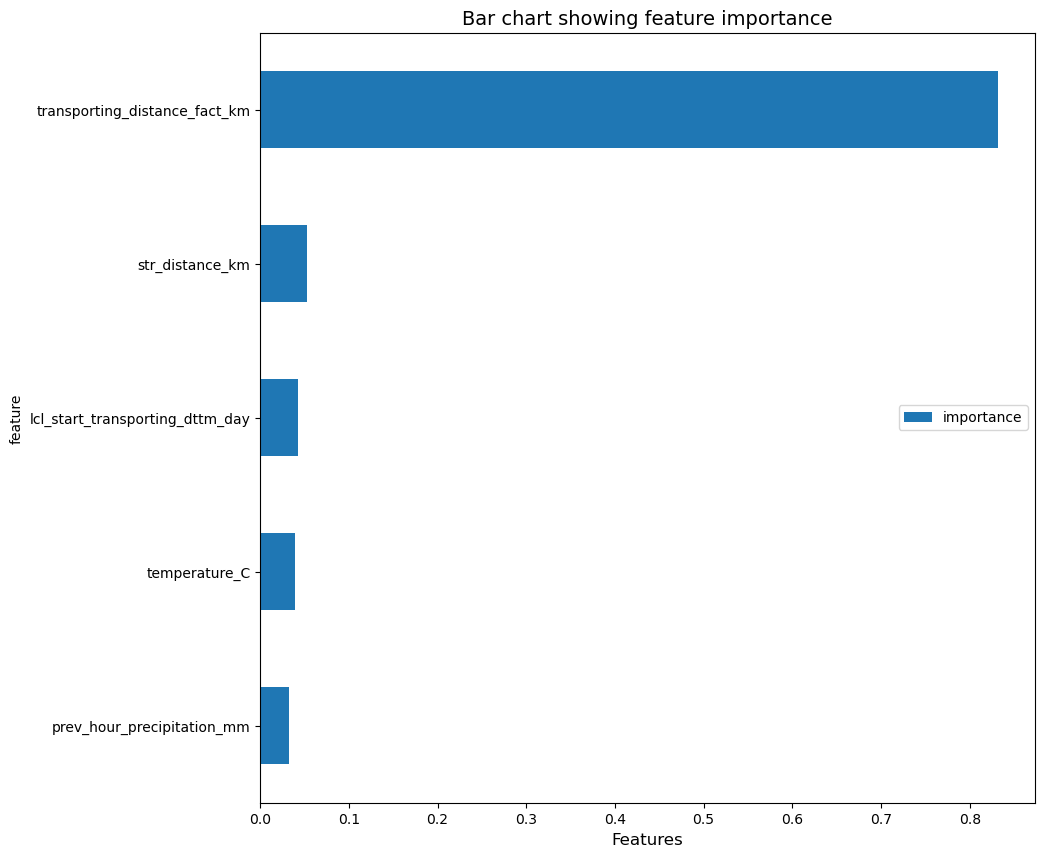

In [14]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()


## Making predictions of the test set and creating a submission file

In [15]:
# Make prediction on the test set
test_df = test[feature_cols].fillna(0)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'trip_id': test.trip_id, 'Target': predictions})
sub_file.head()

,trip_id,Target
0,ID_PV4QVE2H2X,4.799686
1,ID_SUOBMO2E7V,8.508139
2,ID_Q5KSL38U9B,18.043123
3,ID_1G08NWYA35,14.276097
4,ID_H7IZ8JL8YT,7.774021


In [16]:
# Create file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"XGB1_{timestamp}.csv"
sub_file.to_csv("submissions/"+filename, index = False)

# NEURAL NETWORK

In [ ]:
# !pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

# Enhanced feature engineering with proper handling of edge cases
def create_enhanced_features(df):
    df = df.copy()
    
    # Distance ratio (actual vs straight-line) - handle division by zero
    df['distance_ratio'] = np.where(
        df['str_distance_km'] > 0,
        df['transporting_distance_fact_km'] / df['str_distance_km'],
        1.0  # Default ratio when straight-line distance is 0
    )
    
    # Cap extreme values to prevent overflow
    df['distance_ratio'] = np.clip(df['distance_ratio'], 0, 10)  # Reasonable upper bound
    
    # Time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['lcl_start_transporting_dttm_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['lcl_start_transporting_dttm_hour'] / 24)
    
    # Rush hour indicator
    df['rush_hour'] = ((df['lcl_start_transporting_dttm_hour'] >= 7) & 
                       (df['lcl_start_transporting_dttm_hour'] <= 9) |
                       (df['lcl_start_transporting_dttm_hour'] >= 17) & 
                       (df['lcl_start_transporting_dttm_hour'] <= 19)).astype(int)
    
    return df

# Enhanced feature set
enhanced_features = [
    'str_distance_km', 'transporting_distance_fact_km', 'distance_ratio',
    'origin_lat', 'origin_lon', 'destination_lat', 'destination_lon',
    'hour_sin', 'hour_cos', 'rush_hour',
    'lcl_start_transporting_dttm_day', 'temperature_C', 'prev_hour_precipitation_mm'
]

# Prepare data
train_enhanced = create_enhanced_features(train)
test_enhanced = create_enhanced_features(test)

X_enhanced = train_enhanced[enhanced_features].fillna(0)
y_enhanced = train_enhanced['Target']

# Additional check for infinite or NaN values
print("Checking for infinite or NaN values:")
print(f"Infinite values: {np.isinf(X_enhanced).sum().sum()}")
print(f"NaN values: {np.isnan(X_enhanced).sum().sum()}")

# Replace any remaining infinite values with 0
X_enhanced = X_enhanced.replace([np.inf, -np.inf], 0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enhanced)

# Additional check after scaling
print(f"After scaling - Infinite values: {np.isinf(X_scaled).sum()}")
print(f"After scaling - NaN values: {np.isnan(X_scaled).sum()}")

# Split data
X_train_tf, X_val_tf, y_train_tf, y_val_tf = train_test_split(
    X_scaled, y_enhanced, test_size=0.2, random_state=SEED
)

# Build and train model
tf_model = build_tf_model(X_scaled.shape[1])

# Early stopping and model checkpointing
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)
]

history = tf_model.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_val_tf, y_val_tf),
    epochs=200,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
val_predictions = tf_model.predict(X_val_tf)
tf_rmse = np.sqrt(mean_squared_error(y_val_tf, val_predictions))
print(f'TensorFlow NN RMSE: {tf_rmse:.4f}')


In [ ]:
# Make predictions on test set using TensorFlow model
test_enhanced_features = test_enhanced[enhanced_features].fillna(0)

# Replace any infinite values in test set
test_enhanced_features = test_enhanced_features.replace([np.inf, -np.inf], 0)

# Scale test features using the same scaler fitted on training data
test_scaled = scaler.transform(test_enhanced_features)

# Make predictions
test_predictions = tf_model.predict(test_scaled)

# Flatten predictions (remove extra dimension)
test_predictions = test_predictions.flatten()

# Create submission dataframe
submission = pd.DataFrame({
    'trip_id': test['trip_id'],
    'Target': test_predictions
})

# Preview the submission
print("Submission preview:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Target predictions range: {test_predictions.min():.4f} to {test_predictions.max():.4f}")

# Create submission file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"TensorFlow_NN_{timestamp}.csv"
filepath = os.path.join(SUBMISSION_PATH, filename)

submission.to_csv(filepath, index=False)
print(f"\nSubmission file saved as: {filename}")

In [ ]:
# Random Forest with Enhanced Features - Complete Pipeline

# Enhanced feature engineering with proper handling of edge cases
def create_enhanced_features(df):
    df = df.copy()
    
    # Distance ratio (actual vs straight-line) - handle division by zero
    df['distance_ratio'] = np.where(
        df['str_distance_km'] > 0,
        df['transporting_distance_fact_km'] / df['str_distance_km'],
        1.0  # Default ratio when straight-line distance is 0
    )
    
    # Cap extreme values to prevent overflow
    df['distance_ratio'] = np.clip(df['distance_ratio'], 0, 10)  # Reasonable upper bound
    
    # Time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df['lcl_start_transporting_dttm_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['lcl_start_transporting_dttm_hour'] / 24)
    
    # Rush hour indicator
    df['rush_hour'] = ((df['lcl_start_transporting_dttm_hour'] >= 7) & 
                       (df['lcl_start_transporting_dttm_hour'] <= 9) |
                       (df['lcl_start_transporting_dttm_hour'] >= 17) & 
                       (df['lcl_start_transporting_dttm_hour'] <= 19)).astype(int)
    
    return df

# Enhanced feature set
enhanced_features = [
    'str_distance_km', 'transporting_distance_fact_km', 'distance_ratio',
    'origin_lat', 'origin_lon', 'destination_lat', 'destination_lon',
    'hour_sin', 'hour_cos', 'rush_hour',
    'lcl_start_transporting_dttm_day', 'temperature_C', 'prev_hour_precipitation_mm'
]

# Prepare enhanced training data
train_enhanced = create_enhanced_features(train)
test_enhanced = create_enhanced_features(test)

X_enhanced = train_enhanced[enhanced_features].fillna(0)
y_enhanced = train_enhanced['Target']

# Replace any infinite values
X_enhanced = X_enhanced.replace([np.inf, -np.inf], 0)

print(f"Enhanced feature set shape: {X_enhanced.shape}")
print(f"Features: {enhanced_features}")

# Split data for validation
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=SEED
)

# Train Random Forest with enhanced features
rf_model = KNeighborsRegressor()

print("Training Random Forest model...")
rf_model.fit(X_train_rf, y_train_rf)

# Evaluate on validation set
val_predictions = rf_model.predict(X_val_rf)
rf_rmse = np.sqrt(mean_squared_error(y_val_rf, val_predictions))
print(f'Random Forest RMSE: {rf_rmse:.4f}')

# Feature importance
# feature_importance = pd.DataFrame({
#     'feature': enhanced_features,
#     'importance': rf_model.feature_importances_
# }).sort_values('importance', ascending=False)

# print("\nTop 10 Most Important Features:")
# print(feature_importance.head(10))

# Prepare test data and make predictions
test_enhanced_features = test_enhanced[enhanced_features].fillna(0)
test_enhanced_features = test_enhanced_features.replace([np.inf, -np.inf], 0)

# Make predictions on test set
test_predictions = rf_model.predict(test_enhanced_features)

# Create submission dataframe
submission = pd.DataFrame({
    'trip_id': test['trip_id'],
    'Target': test_predictions
})

# Preview the submission
print("\nSubmission preview:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Target predictions range: {test_predictions.min():.4f} to {test_predictions.max():.4f}")

# Create submission file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"KNeighborsRegressor_Enhanced_{timestamp}.csv"
filepath = os.path.join(SUBMISSION_PATH, filename)

submission.to_csv(filepath, index=False)
print(f"\nSubmission file saved as: {filename}")
